In [1]:
import sys

if sys.platform == "win32":
    sys.path.append("D:/DevSpace/Projects/Research/SeizureDetection")
elif sys.platform == "linux":
    sys.path.append("/mnt/d/gniazdko/SeizureDetection")

In [2]:
from torchsummary import summary
import matplotlib.pyplot as plt

from core.utils import ProjectManager, ConfigManager
from core.utils import load_model_input_data

from core.machine_learning import (
    sample_data,
    split_data_by_proportions,
    create_dataloaders,
)

d:\DevSpace\Projects\Research\research_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
project_manager = ProjectManager()
configs_directory_path = project_manager.get_configs_directory_path()
primary_data_path = project_manager.get_primary_data_path()
model_directory_path = project_manager.get_model_data_path()

config_manager = ConfigManager(configs_directory_path)
model_params = config_manager.load_config("parameters_machine_learning")

In [4]:
model_input_data = load_model_input_data(
    primary_data_path, model_params)

model_input_data[0].shape, model_input_data[1].shape

((2321, 1, 18, 64, 64), (2321,))

In [5]:
X, y = model_input_data

X.shape, y.shape

((2321, 1, 18, 64, 64), (2321,))

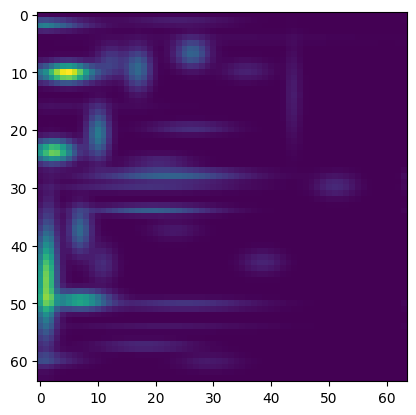

In [6]:
plt.imshow(X[2137, 0, 9, :, :]);

In [7]:
data_splits = split_data_by_proportions(
    model_input_data, model_params["data_parameters"])

train_data, valid_data, test_data = create_dataloaders(
    data_splits, model_params["data_parameters"])

In [8]:
single_batch = next(iter(train_data))


features, targets = single_batch
features, targets = features.to('cuda'), targets.to('cuda')

features.shape, targets.shape

(torch.Size([16, 1, 18, 64, 64]), torch.Size([16]))

In [9]:
model_parameters = model_params["model_parameters"]

In [10]:
from core.machine_learning.model_builder import R2Plus1DConvNet
from core.machine_learning.accuracy import BinaryAccuracy

from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR
from torch.nn import CrossEntropyLoss

In [11]:
model = R2Plus1DConvNet(1, 2, 0)

model = model.to(model_parameters["device"])

In [12]:
model

R2Plus1DConvNet(
  (conv1): Sequential(
    (0): Conv2Plus1D(
      (spatial_convolution): Conv2d(1, 39, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (temporal_convolution): Conv1d(39, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    )
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): ResidualBlock(
    (conv_block): ConvolutionalBlock(
      (convolution): Sequential(
        (0): Conv2Plus1D(
          (spatial_convolution): Conv2d(64, 144, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (temporal_convolution): Conv1d(144, 64, kernel_size=(3,), stride=(2,), padding=(1,))
        )
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2Plus1D(
          (spatial_convolution): Conv2d(64, 144, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (temporal_convolution): Conv1d(144, 64

In [13]:
# summary(model, input_data=(1, 18, 128, 128))

In [14]:
loss_fn = CrossEntropyLoss()
accuracy_fn = BinaryAccuracy()

optimizer = SGD(
    params=model.parameters(),
    lr=model_parameters["learning_rate"],
    weight_decay=model_parameters["weight_decay"])
    
lr_scheduler = StepLR(
    optimizer,
    step_size=model_parameters["step_size"],
    gamma=model_parameters["gamma"])

In [15]:
features.shape

torch.Size([16, 1, 18, 64, 64])

In [16]:
output = model(features)
output

input shape: torch.Size([16, 1, 18, 64, 64])
conv1 output shape: torch.Size([16, 64, 18, 32, 32])
conv2 output shape: torch.Size([16, 64, 9, 16, 16])
conv3 output shape: torch.Size([16, 128, 5, 8, 8])
conv4 output shape: torch.Size([16, 256, 3, 4, 4])
conv5 output shape: torch.Size([16, 512, 2, 2, 2])
avgpool output shape: torch.Size([16, 512, 1, 1, 1])
flatten output shape: torch.Size([16, 512])
fc output shape: torch.Size([16, 2])


tensor([[0.1209, 0.2545],
        [0.1122, 0.1963],
        [0.0908, 0.1898],
        [0.3419, 0.4259],
        [0.1017, 0.1592],
        [0.1747, 0.1304],
        [0.1732, 0.1441],
        [0.1629, 0.1897],
        [0.0969, 0.2236],
        [0.1365, 0.1790],
        [0.1353, 0.2070],
        [0.1474, 0.2446],
        [0.1109, 0.1730],
        [0.1841, 0.3422],
        [0.1975, 0.1178],
        [0.1176, 0.2594]], device='cuda:0', grad_fn=<AddmmBackward0>)